In [1]:
import networkx as nx
from collections import Counter
from nltk.corpus import wordnet as wn
print('Corpus imported') # it takes time

Corpus imported


**4.5 + 1 балл**: Построим граф колексификаций. Я взяла за основу синсет travel.v.01, но тестировала работу кода с рандомными датасетами.
### **ВАЖНО!** Граф большой. Не забудьте нажать кнопочку "Stop interaction", чтобы он перестал обращаться к серверу. Вот тот же граф, но картинкой (он есть в папке): <img src="colexification.png" width="800" />

<IPython.core.display.Javascript object>


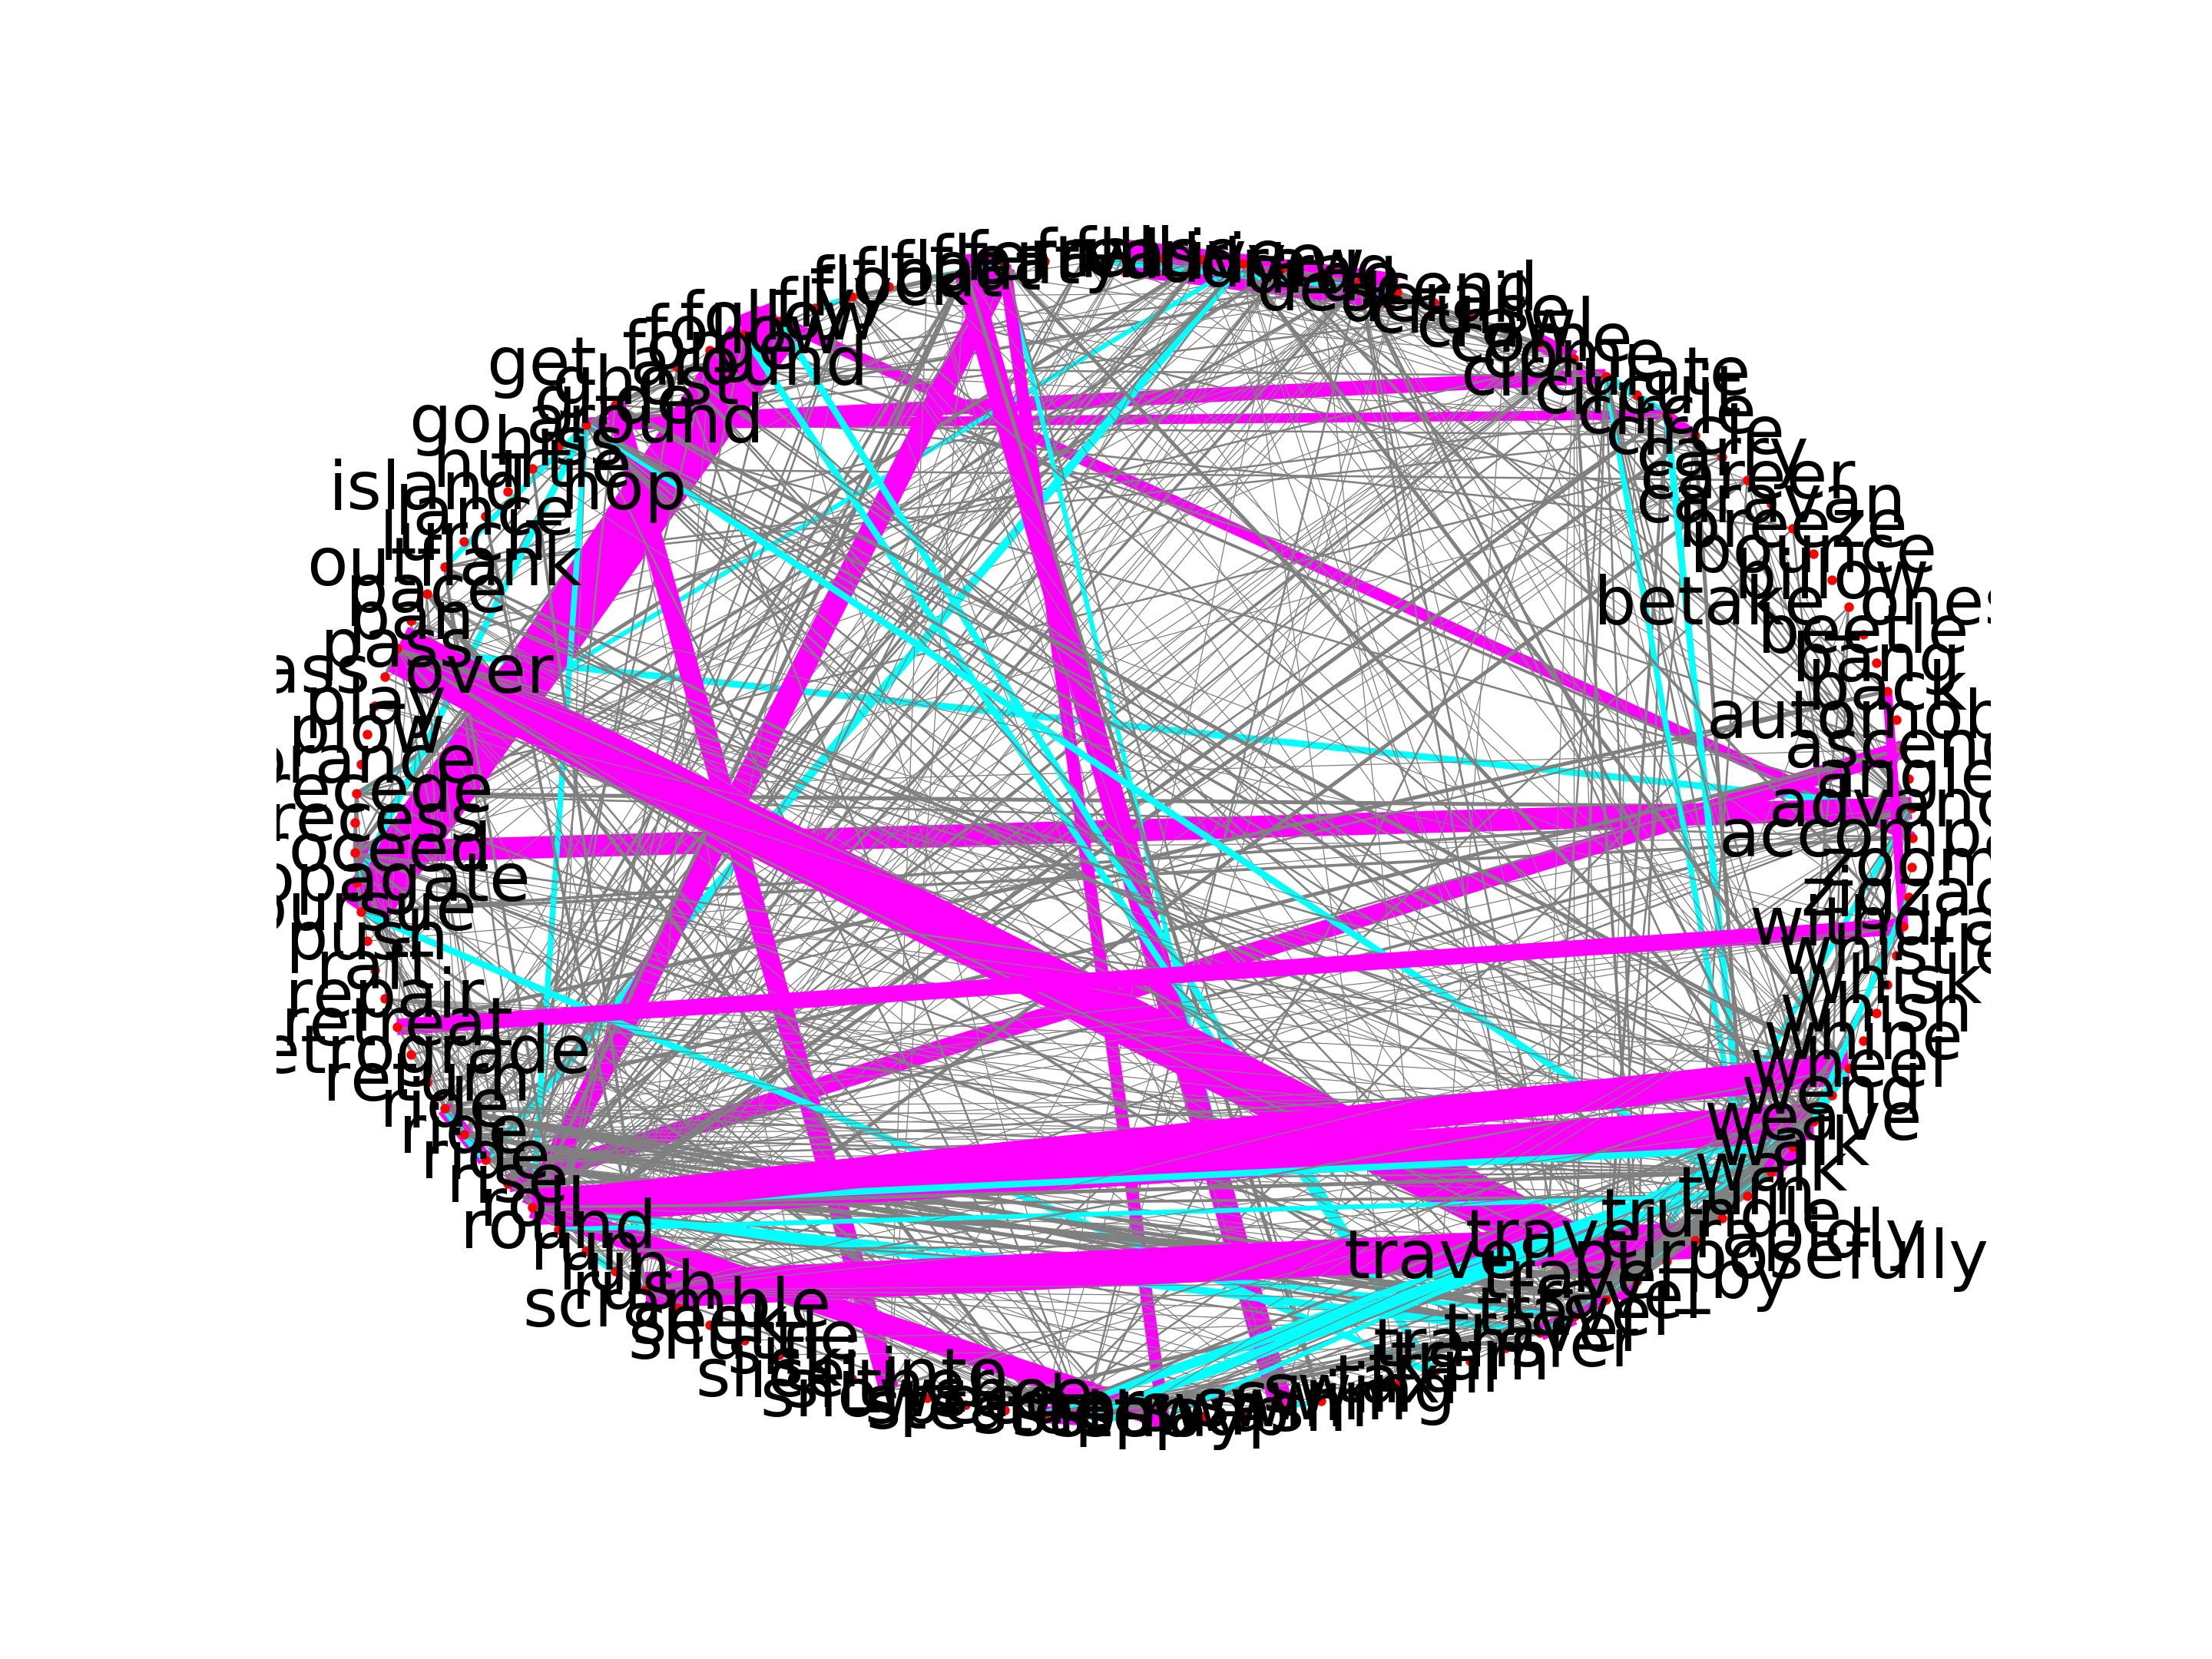

In [6]:
%matplotlib notebook
%matplotlib notebook
# for bizarre reasons, works better if imported twice
import matplotlib.pyplot as plt
# sorting data
snst = wn.synset('travel.v.01')
hpnms = snst.hyponyms()
langs = sorted(wn.langs())
G = nx.Graph()
G.add_nodes_from(hpnms)
nodes = []
for i, base in enumerate(hpnms):
    for j in langs:
        one = base.lemma_names(j)
        for k in range(len(hpnms)):
            two = hpnms[k].lemma_names(j)
            if any(map(lambda v: v in one, two)) and base != hpnms[k]:
                for y in two:
                    if y in one:
                        nodes.append((base, hpnms[k]))
nodes = dict(Counter(nodes))
for keys, values in nodes.items():
    G.add_edge(keys[0], keys[1], weight=values)

# visualisation
pos = nx.shell_layout(G) # I'm using shell, but none of them make real sense here
nx.draw_networkx_nodes(G, pos, node_color='red', node_size=1)
for n in G.edges(data=True):
    if n[2]['weight'] < 5:
        colour = 'gray'
    elif 5 <= n[2]['weight'] < 10:
        colour = 'cyan'
    else:
        colour = 'magenta'
    nx.draw_networkx_edges(G, pos, edgelist=[(n[0], n[1])], width=n[2]['weight']/5, edge_color=colour)
nodes = {i: i.name().split('.')[0] for i in G.nodes}
nx.draw_networkx_labels(G, pos, font_size=14, font_family='sans-serif', labels=nodes)
plt.axis('off')
plt.rcParams['figure.dpi'] = 300
plt.show()

**1.5 балла**: Обсчитаем некоторые метрики: количество связных компонент, коэффициент ассортативности и плотность графа.

In [3]:
print('Число узлов: ', len(G.nodes()))  # ради сравнения с количеством связных
print('Число связных компонент:', nx.number_connected_components(G))
print('Коэффициент ассортативности: ', nx.degree_assortativity_coefficient(G))
print('Плотность графа: ', nx.density(G))

Число узлов:  123
Число связных компонент: 26
Коэффициент ассортативности:  0.07961415763622523
Плотность графа:  0.08436625349860057


**2 балла**: Посчитаем и проанализируем взвешенные степени узлов в сравнении с метриками degree centrality, betweenness centrality и eigencentrality.
_Degree centrality_ - метрика, которая отражает количество связей между узлами: узел, у которого больше связей, более важный (в данном случае - узел, с которым чаще всего колексифицируются другие). "Важность" узла roll также отражает метрика взвешенной степени, которая при расчёте степени учитывает её вес (я использую определение weighted degree (_'it's based on the number of edge for a node, but ponderated by the weigtht of each edge'_), которое я нашла в других туториалах, поскольку в документации networkx, на которую ссылается хэндаут, я не нашла расчёта этой метрики по описанному алгоритму).

_Betweenness centrality_ - это метрика, отражающая количество шагов, которое нужно, чтобы достичь точки B из точки А в графе. Соответственно, узел с максимальной betweenness centrality - это узел, через который проходит наибольшее число минимальных троп. Относительно колексификации такой узел выступает в роли "перевалочного пункта", через который связываются разные значения глаголов путешествия, поэтому там появляются дополнительные значения типа "торопиться".

_Eigenvector centrality_ зависит от центральности ближайших узлов, т.е. чем больше узел связан с "влиятельными" узлами, тем он сам влиятельнее. Набор самых влиятельных узлов (follow x 2, pursue, trail, accompany) составлен из дополнительных значений глаголов передвижения, которые часто колексифицируются: двигаться не бесцельно, а вслед за каким-то объектом. Также здесь выражается goal bias: появляется значение цели, но оно слабо маркировано (т.е. нет отдельного глагола).

Взвешенные степени узлов отражают частоту и "силу" колексификации: как часто какое-то значение колексифицируется с другим и насколько большом наборе языков (однако, поскольку метрика считалась по внешней форме слова, а в некоторых языках не представлены леммы, иногда результаты недостаточно точны). Самая малая степень у значений, которые реже всего колексифицируются (например, _hiss_ = 1, т.е только один язык связал это значение с глаголом, более точно относящимся к глаголам передвижения).

In [4]:
print('Взвешенные степени узлов:')
wd = dict(G.degree(weight='weight'))
for i, k in wd.items():
    print(f'{i.name().split(".")[0]}: {k}', end='\t')

print('\n\nМетрики: degree centrality, betweenness centrality, eigencentrality:')
dgr = nx.degree_centrality(G)
dgr = sorted(dgr, key=dgr.get, reverse=True)[:5]
print('Узлы с наивысшей degree centrality:')
for i in dgr:
    print(i.name().split('.')[0], end='\t')
btw = nx.betweenness_centrality(G, weight='weight')
btw = sorted(btw, key=btw.get, reverse=True)[:5]
print('\nУзлы с наивысшей betweenness centrality:')
for i in btw:
    print(i.name().split('.')[0], end='\t')
eig = nx.eigenvector_centrality(G, weight='weight')
eig = sorted(eig, key=eig.get, reverse=True)[:5]
print('\nУзлы с наивысшей eigencentrality:')
for i in eig:
    print(i.name().split('.')[0], end='\t')

Взвешенные степени узлов:
accompany: 21	advance: 87	angle: 0	ascend: 33	automobile: 0	back: 18	bang: 0	beetle: 0	betake_oneself: 7	billow: 0	bounce: 0	breeze: 8	caravan: 0	career: 13	carry: 16	circle: 24	circle: 52	circuit: 3	circulate: 52	come: 55	come: 30	crawl: 4	cruise: 7	derail: 0	descend: 66	do: 47	drag: 2	draw: 32	drive: 45	drive: 32	ease: 0	fall: 56	fall: 26	ferry: 1	float: 102	float: 85	float: 15	flock: 0	fly: 33	fly: 8	follow: 123	follow: 93	forge: 8	get_around: 20	ghost: 0	glide: 40	go_around: 88	hiss: 1	hurtle: 8	island_hop: 0	lance: 5	lurch: 0	outflank: 24	pace: 20	pan: 7	pass: 90	pass_over: 6	play: 2	plow: 0	prance: 0	precede: 32	precess: 0	proceed: 73	propagate: 11	pursue: 120	push: 4	raft: 2	repair: 16	retreat: 35	retrograde: 2	return: 7	ride: 66	ride: 53	ride: 75	rise: 54	roll: 203	round: 25	run: 26	run: 21	rush: 77	scramble: 2	seek: 0	shuttle: 1	sift: 2	ski: 1	slice_into: 0	slither: 31	snowshoe: 0	speed: 8	steamer: 0	step: 69	step: 76	step: 30	stray: 43	swap: 0	swash:

**2 балла**: Разобьём граф на сообщества и кратко рассмотрим результаты разных алгоритмов (я сравниваю три).

Все три алгоритма "считают", что выборка разбивается примерно на 30 сообществ. Кроме этого, у всех алгоритмов очень много совпадений по попаданиям в сообщество: например, сообщество _{whish, zoom}_ присутствует в такой форме во всех алгоритмах. Любопытно попадание глагола _repair_ в основные сообщества: можно предположить, что это связано с его высокой eigencentrality или betweenness centrality (у него средняя EC и относительно высокая BC), т.е. он связан с главными точками графа. Также интересно, что глаголы звука _{hiss, whistle}_ также - и это совпадает с наивной интуицией - отделяются в отдельное сообщество.

In [5]:
def print_coms(com):
    for i, c in enumerate(com):
        c = " ".join([i.name().split('.')[0] for i in c])
        print(f"{i+1}: {c}")


from networkx.algorithms import community
print('Разбиение по модулярности:')
modularity = community.greedy_modularity_communities(G)
print_coms(modularity)
print('\nРазбиение по Гирвану:')
girvan = community.girvan_newman(G)
girvan_1 = next(girvan)
girvan_2 = next(girvan)
girvan_3 = next(girvan)
print_coms(girvan_3)
print('\nРазбиение алгоритмом лейбелинга:')
lpc = community.label_propagation_communities(G)
print_coms(lpc)

Разбиение по модулярности:
1: ski wheel follow pursue go_around hurtle shuttle travel_purposefully circulate return roll travel run wend career raft come lance proceed back withdraw step travel pass_over cruise breeze propagate fall ascend play come betake_oneself retrograde crawl run rush turn follow speed forge float pan outflank ferry walk retreat scramble weave step ride circuit whisk descend tram accompany fly swim travel do glide repair sift precede circle advance step trail pass pace draw stray fall walk float travel_rapidly swim swing ride round drive float transfer circle fly carry drive travel_by get_around push taxi rise slither ride zigzag drag
2: whistle hiss
3: whish zoom
4: angle
5: automobile
6: bang
7: beetle
8: billow
9: bounce
10: caravan
11: derail
12: ease
13: flock
14: ghost
15: island_hop
16: lurch
17: plow
18: prance
19: precess
20: seek
21: slice_into
22: snowshoe
23: steamer
24: swap
25: swash
26: trundle
27: whine

Разбиение по Гирвану:
1: ski wheel follow pu